In [1]:
# %load_ext autoreload
# %autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import time
import copy 

import torch
import torchvision

import pandas as pd
import sklearn

from torchvision import transforms, utils
import PIL
from torch.autograd import Variable


import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

In [2]:
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!mkdir -p data
!cp '/content/drive/Shareddrives/UCI CS175 Team23/training_solutions_rev1.csv' ./data/
!unzip -q -u '/content/drive/Shareddrives/UCI CS175 Team23/images_training_rev1.zip' -d ./data/

In [4]:
!ls data

images_training_rev1  training_solutions_rev1.csv


In [5]:
training_data_path = '/content/data/images_training_rev1'
solution_path = '/content/data/training_solutions_rev1.csv'

In [6]:
df = pd.read_csv(solution_path)

In [7]:
df.head()

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,Class5.1,Class5.2,Class5.3,Class5.4,Class6.1,Class6.2,Class7.1,Class7.2,Class7.3,Class8.1,Class8.2,Class8.3,Class8.4,Class8.5,Class8.6,Class8.7,Class9.1,Class9.2,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,0.0,0.104752,0.512101,0.000000,0.054453,0.945547,0.201463,0.181684,0.000000,0.0,0.027226,0.000000,0.027226,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,0.0,0.236781,0.160941,0.234877,0.189149,0.810851,0.000000,0.135082,0.191919,0.0,0.000000,0.140353,0.000000,0.048796,0.000000,0.0,0.012414,0.0,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,0.0,0.117790,0.059562,0.000000,0.000000,1.000000,0.000000,0.741864,0.023853,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,0.0,0.000000,0.113284,0.125280,0.320398,0.679602,0.408599,0.284778,0.000000,0.0,0.000000,0.096119,0.096119,0.000000,0.128159,0.0,0.000000,0.0,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.029383,0.970617,0.494587,0.439252,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.029383,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


In [8]:
df.iloc[0,1:].to_numpy()

array([0.383147  , 0.616853  , 0.        , 0.        , 0.616853  ,
       0.03845215, 0.57840085, 0.41839782, 0.19845518, 0.        ,
       0.10475213, 0.51210087, 0.        , 0.054453  , 0.945547  ,
       0.20146252, 0.18168448, 0.        , 0.        , 0.0272265 ,
       0.        , 0.0272265 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.27995249, 0.13844533,
       0.        , 0.        , 0.09288557, 0.        , 0.        ,
       0.        , 0.32551225])

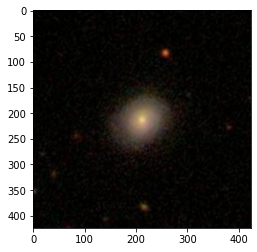

In [9]:
plt.imshow(plt.imread(training_data_path + "/" + str(df["GalaxyID"][0]) + ".jpg"))

In [10]:
# reference: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
class GalaxyDataset(torch.utils.data.Dataset):
  def __init__(self, csv_file, usr_root_dir, usr_transforms=None):
    self.solution = pd.read_csv(solution_path)
    self.root_dir = usr_root_dir
    self.transforms = usr_transforms

  def __len__(self):
    return len(self.solution)
  
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    
    img_name = self.root_dir + "/" + str(self.solution.iloc[idx,0]) + ".jpg"
    #image = plt.imread(img_name).T
    image = PIL.Image.open((img_name))
    image = self.transforms(image)
    proba = self.solution.iloc[idx,1:].to_numpy()
    #image = np.moveaxis(image.numpy()*255, 0, -1).astype("uint8")
    return image, proba

In [11]:
galaxy_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor()
    ])

tri_full = GalaxyDataset(solution_path, training_data_path, galaxy_transform)

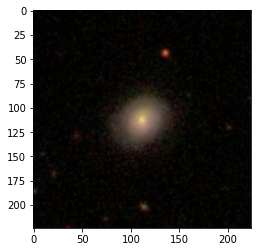

In [12]:
example_img = np.moveaxis(tri_full[0][0].numpy()*255, 0, -1).astype("uint8")
plt.imshow(example_img)

In [13]:
a, b = torch.utils.data.random_split(tri_full, [43104, 18474], torch.Generator().manual_seed(1234))

loader_train = torch.utils.data.DataLoader(a, batch_size=64)
loader_valid = torch.utils.data.DataLoader(b)

gpu_dtype = torch.cuda.FloatTensor

In [14]:
def custom_train(model, loss_fn, optimizer, num_epochs = 1):
    epoch_log = []
    for epoch in range(num_epochs):
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
        model.train()

        t_log = []
        for t, (x, y) in enumerate(loader_train):
            x_var = Variable(x.type(gpu_dtype))
            y_var = Variable(y.type(gpu_dtype))
            
            scores = model(x_var)
            loss = loss_fn(scores, y_var)
            
            if (t + 1) % 500 == 0:
                print('t = %d, loss = %.4f' % (t + 1, loss.item()))
            t_log.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        epoch_log.append(max(t_log))   
    
    fig = plt.figure(figsize=(7,7))
    plt.plot(epoch_log)
    plt.ylim(0, 3)
    plt.title("Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

In [15]:
def check_accuracy(model, loader):
    model.eval() 
    temp = torch.ones([1,37]).type(gpu_dtype)
    count = 0
    with torch.no_grad():
      for x, y in loader:
          # 
          x_var = Variable(x.type(gpu_dtype))
          y_var = Variable(y.type(gpu_dtype))
          
          scores = model(x_var)
          diff = y_var - scores
          
          #temp += torch.square(diff)
          temp += torch.sqrt(torch.mean(torch.square(diff)))
          #temp += diff


    #print(torch.sqrt(torch.mean(torch.div(temp, len(loader)))))
    print( temp / len(loader) )
    #print(torch.sqrt(torch.mean(torch.square(torch.div(temp, len(loader))))))
  

In [16]:
effnet = EfficientNet.from_name("efficientnet-b0")
effnet._fc = nn.Linear(1280, 37)
effnet.cuda()
opt = optim.SGD(effnet.parameters(), lr=0.1)

Starting epoch 1 / 25
t = 500, loss = 0.0269
Starting epoch 2 / 25
t = 500, loss = 0.0211
Starting epoch 3 / 25
t = 500, loss = 0.0180
Starting epoch 4 / 25
t = 500, loss = 0.0175
Starting epoch 5 / 25
t = 500, loss = 0.0163
Starting epoch 6 / 25
t = 500, loss = 0.0152
Starting epoch 7 / 25
t = 500, loss = 0.0141
Starting epoch 8 / 25
t = 500, loss = 0.0139
Starting epoch 9 / 25
t = 500, loss = 0.0131
Starting epoch 10 / 25
t = 500, loss = 0.0128
Starting epoch 11 / 25
t = 500, loss = 0.0119
Starting epoch 12 / 25
t = 500, loss = 0.0115
Starting epoch 13 / 25
t = 500, loss = 0.0111
Starting epoch 14 / 25
t = 500, loss = 0.0119
Starting epoch 15 / 25
t = 500, loss = 0.0108
Starting epoch 16 / 25
t = 500, loss = 0.0107
Starting epoch 17 / 25
t = 500, loss = 0.0121
Starting epoch 18 / 25
t = 500, loss = 0.0101
Starting epoch 19 / 25
t = 500, loss = 0.0101
Starting epoch 20 / 25
t = 500, loss = 0.0100
Starting epoch 21 / 25
t = 500, loss = 0.0092
Starting epoch 22 / 25
t = 500, loss = 0.01

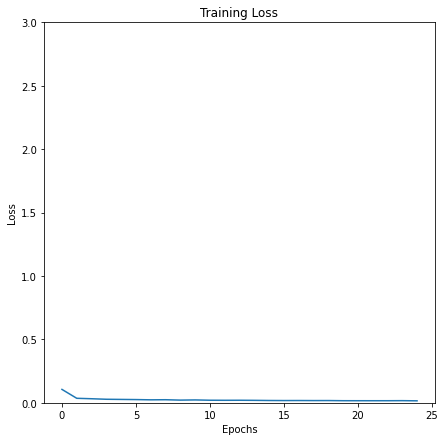

In [17]:

loss = nn.MSELoss().type(gpu_dtype)
custom_train(effnet, loss, opt, 25)

In [18]:
check_accuracy(effnet, loader_valid)

tensor([[0.1014, 0.1014, 0.1014, 0.1014, 0.1014, 0.1014, 0.1014, 0.1014, 0.1014,
         0.1014, 0.1014, 0.1014, 0.1014, 0.1014, 0.1014, 0.1014, 0.1014, 0.1014,
         0.1014, 0.1014, 0.1014, 0.1014, 0.1014, 0.1014, 0.1014, 0.1014, 0.1014,
         0.1014, 0.1014, 0.1014, 0.1014, 0.1014, 0.1014, 0.1014, 0.1014, 0.1014,
         0.1014]], device='cuda:0')


In [19]:
torch.save(effnet, "effnet.pt")

In [ ]:
effnet.state_dict()

In [35]:
loaded_model = torch.load('/content/drive/Shareddrives/UCI CS175 Team23/effnet-b3.pt' )

In [38]:
loaded_model.state_dict()

OrderedDict([('2._conv_stem.weight', tensor([[[[ 0.0931, -0.0861,  0.0881],
                        [ 0.0170, -0.0513,  0.1807],
                        [ 0.2430,  0.1199, -0.0536]],
              
                       [[-0.0270, -0.0067,  0.2047],
                        [ 0.2362, -0.1081, -0.0449],
                        [ 0.0087,  0.1740,  0.1065]],
              
                       [[-0.0995, -0.0484, -0.0708],
                        [-0.0361,  0.1841,  0.0443],
                        [-0.0115,  0.0006, -0.1210]]],
              
              
                      [[[ 0.0935,  0.1491,  0.0015],
                        [-0.1411, -0.0098,  0.0490],
                        [ 0.1573,  0.1701, -0.1038]],
              
                       [[ 0.1489, -0.0551, -0.0166],
                        [-0.1323,  0.1362,  0.0290],
                        [-0.0541,  0.2141, -0.0467]],
              
                       [[ 0.0811, -0.1369,  0.0119],
                        [ 0.1281,

In [ ]:
check_accuracy(loaded_model, loader_valid)


In [20]:
!cp effnet.pt "/content/drive/Shareddrives/UCI CS175 Team23/"

In [395]:
fixed_model_gpu.named_parameters

<bound method Module.named_parameters of Sequential(
  (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1))
  (1): ReLU(inplace=True)
  (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): Linear(in_features=5408, out_features=1024, bias=True)
  (6): ReLU(inplace=True)
  (7): Linear(in_features=1024, out_features=37, bias=True)
)>

In [7]:
loader = DataLoader('/content/data/images_training_rev1', '/content/data/training_solutions_rev1.csv')
rng = np.random.default_rng()

In [8]:
solutions = loader.load_all_solutions()
rng.shuffle(solutions)
split_point = int(solutions.shape[0] * 0.7)
training, validation = solutions[:split_point], solutions[split_point:]
print(training.shape)
print(validation.shape)

(43104, 38)
(18474, 38)


In [473]:
effnet = EfficientNet.from_name("efficientnet-b0")
effnet._fc = nn.Linear(1280, 37)

In [231]:
fixed_model_base = nn.Sequential( # You fill this in!
                    nn.Conv2d(3, 32, kernel_size=7, stride=1),
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(32),
                    nn.MaxPool2d(2, 2),

                    nn.Flatten(),
                    nn.Linear(5408, 1024),
                    nn.ReLU(inplace=True),
                    nn.Linear(1024, 37)
                )

fixed_model_gpu = fixed_model_base.type(torch.cuda.FloatTensor)

In [26]:
resnet18 = fixed_model#effnet

In [27]:
import torchvision.transforms as transforms
from lib.pytorch_preprocess import NormalizeImages

resnet_model = nn.Sequential(
    transforms.Resize(32),
    NormalizeImages(),
    resnet18
).type(torch.cuda.FloatTensor)

resnet_model.apply(random_weights)
resnet_optimizer = optim.SGD(resnet_model.parameters(), lr=0.1)

In [300]:
import time
from lib.training import train
from lib.training import batch_predict_eval

def validation_cuda_rmse(model):
  def extract_predictions(scores):
    torch.cuda.synchronize()
    return scores.data.cpu().numpy()
  validation_predictions = batch_predict_eval(validation, loader, model, dtype=torch.cuda.FloatTensor, extract_predictions=extract_predictions)
  diff = validation_predictions - validation[:, 1:]
  rmse = np.sqrt(np.mean(np.square(diff)))
  return rmse

In [28]:
resnet_optimizer = optim.SGD(resnet_model.parameters(), lr=0.1)

In [158]:
start_time = time.time()
timing_log = []
loss_record = []

loss_fn = nn.MSELoss()
res_lr_sched = optim.lr_scheduler.MultiplicativeLR(resnet_optimizer, lambda epoch: 0.9)

train(
    training, 
    a,
    #loader,
    resnet_model, 
    loss_fn.type(torch.cuda.FloatTensor), 
    resnet_optimizer,
    num_epochs=1, 
    #batch_size = 100,
    iter_per_batch = 1, 
    lr_scheduler= res_lr_sched, 
    dtype=torch.cuda.FloatTensor,
    timing_log=timing_log, loss_record=loss_record
)
end_time = time.time()

print('Training time {:.3f} seconds'.format(end_time - start_time))

AttributeError: ignored

In [30]:
validation_cuda_rmse(resnet_model)

0.13876649669811067